In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.recommendation import ALS

from pyspark.sql.functions import lit
from pyspark.sql.functions import isnan, when, count, col

from pyspark.sql import SparkSession

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
ratings = pd.read_csv('data/training.csv')


In [3]:
# Create a TRAINING and VALIDATION set. validation set will be the
# last 20% of the training set, ordered by date
ratings = ratings.sort_values(by='timestamp').reset_index(drop=True)
training = ratings.loc[:len(ratings)*.8-1, :].copy()
validation = ratings.loc[len(ratings)*.8:, :].copy()

In [4]:
training = training.drop('timestamp', axis=1)
validation = validation.drop('timestamp', axis=1)

In [5]:
train = spark.createDataFrame(training)
test = spark.createDataFrame(validation)

In [6]:
density = (train.count() / (train.select('user').distinct().count() * train.select('movie').distinct().count()))

print(f'Density of training data: {density * 100:.2f}%')

Density of training data: 3.99%


# Compare Ranks of ALS models


In [17]:
ranks = np.arange(1,27)[::2]
ranks

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25])

In [29]:
predictions_test.show()

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
| 673|  148|     5|       NaN|
|1242|  148|     3|       NaN|
|1069|  148|     2|       NaN|
|1605|  148|     2| 1.9660332|
|1150|  148|     2|       NaN|
| 660|  463|     3|       NaN|
|1069|  463|     2|       NaN|
|1146|  463|     2|       NaN|
| 746|  463|     1|       NaN|
|1980|  463|     2|  2.344157|
|1395|  471|     5|       NaN|
|1303|  471|     4|       NaN|
|1199|  471|     3|       NaN|
|1404|  471|     3|       NaN|
|1441|  471|     5|       NaN|
|1496|  471|     2|       NaN|
|1156|  471|     3|       NaN|
| 731|  471|     5|       NaN|
|1019|  471|     4|       NaN|
|1294|  471|     4|       NaN|
+----+-----+------+----------+
only showing top 20 rows



In [32]:
import numpy as np

The percent of NaNs in predictions for model with rank 20: 79.26%
Average squared error of predictions for model with rank 20: 1.23
Root Mean Squared Error of Predictions for model with rank 20: 1.11
Standard Deviation of True Ratings: 1.12
Standard Deviation of Prediction for model with rank 20: 0.33
RMSE Percentage for model with rank 20: 31.49%


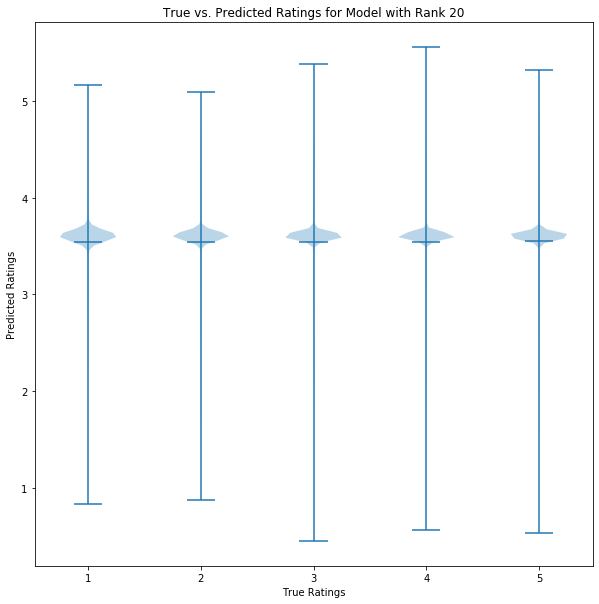

In [14]:
# for r in ranks:
r = 20

model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=r)

# Train the ALS model
recommender = model.fit(train)

# predict on training data
#predictions_train = recommender.transform(train)

predictions_test = recommender.transform(test)

predictions_pandas = predictions_test.toPandas()

count_nans_prediction = predictions_pandas['prediction'].isna().sum()

percent_nans = count_nans_prediction / predictions_pandas.shape[0]

print(f"The percent of NaNs in predictions for model with rank {r}: {percent_nans*100:.2f}%")

predictions_pandas = predictions_pandas.fillna(training['rating'].mean())

predictions_pandas['squared_error'] = (predictions_pandas['rating'] - predictions_pandas['prediction'])**2

avg_sq_err = predictions_pandas.describe()['squared_error']['mean']
print(f'Average squared error of predictions for model with rank {r}: {avg_sq_err:.2f}')

# Calculate RMSE
rmse = np.sqrt(sum(predictions_pandas['squared_error']) / len(predictions_pandas))
print(f'Root Mean Squared Error of Predictions for model with rank {r}: {rmse:.2f}')

std_rating = ratings.describe()['rating']['std']
std_pred = predictions_pandas.describe()['prediction']['std']

print(f'Standard Deviation of True Ratings: {std_rating:.2f}')
print(f'Standard Deviation of Prediction for model with rank {r}: {std_pred:.2f}')

_mean = predictions_pandas['rating'].mean()
rmsep = rmse / _mean
print(f'RMSE Percentage for model with rank {r}: {rmsep * 100:.2f}%')

# Create array of predictions for violinplot
data = [predictions_pandas['prediction'][ratings['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,10))
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'True vs. Predicted Ratings for Model with Rank {r}')
plt.show()


The percent of NaNs in predictions for model with rank 50: 79.26%
Average squared error of predictions for model with rank 50: 1.23
Root Mean Squared Error of Predictions for model with rank 50: 1.11
Standard Deviation of True Ratings: 1.12
Standard Deviation of Prediction for model with rank 50: 0.33
RMSE Percentage for model with rank 50: 31.48%


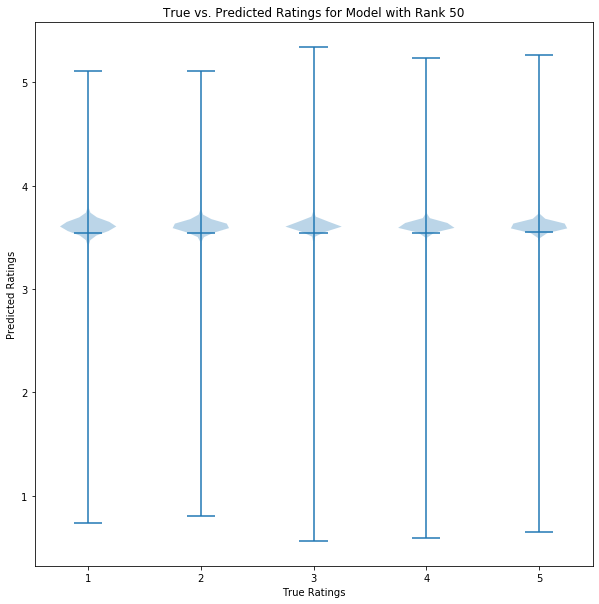

In [17]:
# for r in ranks:
r = 50

model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=r)

# Train the ALS model
recommender = model.fit(train)

# predict on training data
#predictions_train = recommender.transform(train)

predictions_test = recommender.transform(test)


predictions_pandas = predictions_test.toPandas()

count_nans_prediction = predictions_pandas['prediction'].isna().sum()

percent_nans = count_nans_prediction / predictions_pandas.shape[0]

print(f"The percent of NaNs in predictions for model with rank {r}: {percent_nans*100:.2f}%")

predictions_pandas = predictions_pandas.fillna(training['rating'].mean())

predictions_pandas['squared_error'] = (predictions_pandas['rating'] - predictions_pandas['prediction'])**2

avg_sq_err = predictions_pandas.describe()['squared_error']['mean']
print(f'Average squared error of predictions for model with rank {r}: {avg_sq_err:.2f}')

# Calculate RMSE
rmse = np.sqrt(sum(predictions_pandas['squared_error']) / len(predictions_pandas))
print(f'Root Mean Squared Error of Predictions for model with rank {r}: {rmse:.2f}')

std_rating = ratings.describe()['rating']['std']
std_pred = predictions_pandas.describe()['prediction']['std']

print(f'Standard Deviation of True Ratings: {std_rating:.2f}')
print(f'Standard Deviation of Prediction for model with rank {r}: {std_pred:.2f}')

_mean = predictions_pandas['rating'].mean()
rmsep = rmse / _mean
print(f'RMSE Percentage for model with rank {r}: {rmsep * 100:.2f}%')

# Create array of predictions for violinplot
data = [predictions_pandas['prediction'][ratings['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,10))
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'True vs. Predicted Ratings for Model with Rank {r}')
plt.show()


In [61]:
yhat_train.select([count(when(isnan(c), c)).alias(c) for c in yhat_train.columns]).show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|   0|    0|     0|        0|         0|
+----+-----+------+---------+----------+



In [62]:
yhat_train.show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|4227|  148|     2|965659724| 2.1379628|
|3184|  148|     4|968708953| 3.2579472|
|4784|  148|     3|970000570| 2.9012449|
|2383|  148|     2|974417654| 2.3509796|
|3539|  148|     3|966932408| 2.7074847|
|3829|  148|     2|965940170| 2.3784328|
|2456|  148|     2|974178993| 2.4450996|
|2507|  148|     4|974082717| 3.1364677|
|3053|  148|     3|970170090|  2.677186|
|3841|  463|     3|966003085|  2.566588|
|3650|  463|     2|966459084|  2.589714|
|3151|  463|     5|968916009| 3.9177732|
|4858|  463|     3|963746396| 2.4707265|
|2629|  463|     4|973625620| 3.1455767|
|3328|  463|     4|967918151| 3.1497078|
|4040|  463|     1|965505136| 1.7982821|
|4277|  463|     4|965469038| 3.3358335|
|2051|  463|     1|974663178| 1.9354658|
|3753|  463|     2|966184754| 2.2116852|
|5047|  463|     3|966134684| 2.2635717|
+----+-----+------+---------+----------+
only showing top

In [63]:
predictions = recommender.transform(test)

In [64]:
# nans in the testing prediction
predictions.select([count(when(isnan(c), c)).alias(c) for c in yhat_train.columns]).show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|   0|    0|     0|        0|    126058|
+----+-----+------+---------+----------+



# Evaluate baseline

In [65]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [66]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [67]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [68]:
predictions_df.head()

,user,movie,rating,timestamp,prediction,squared_error
0,673,148,5,975620824,3.606881,1.940779
1,1242,148,3,974909976,3.606881,0.368305
2,1069,148,2,974945135,3.606881,2.582068
3,1605,148,2,974930221,1.980308,0.000388
4,1150,148,2,974875106,3.606881,2.582068


In [69]:
predictions_df.describe()

,user,movie,rating,timestamp,prediction,squared_error
count,158176.000000,158176.000000,158176.000000,1.581760e+05,158176.000000,1.581760e+05
mean,1280.579235,1868.670829,3.523923,9.750753e+08,3.545189,1.235456e+00
std,516.866310,1103.873411,1.146110,3.016431e+05,0.329173,1.646257e+00
min,636.000000,1.000000,1.000000,9.747400e+08,0.290563,4.604317e-10
25%,935.000000,1025.000000,3.000000,9.748185e+08,3.606881,1.545423e-01
50%,1202.000000,1836.000000,4.000000,9.749512e+08,3.606881,3.683050e-01
75%,1491.000000,2770.000000,4.000000,9.753519e+08,3.606881,1.940779e+00
max,5996.000000,3952.000000,5.000000,9.757673e+08,5.577134,1.247443e+01


In [74]:
avg_sq_err = predictions_df.describe()['squared_error']['mean']
print(f'Average squared error of predictions: {avg_sq_err:.2f}')

Average squared error of predictions: 1.24


In [76]:
# Calculate RMSE
rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
print(f'Root Mean Squared Error of Predictions: {rmse:.2f}')

Root Mean Squared Error of Predictions: 1.11


In [83]:
std_rating = predictions_df.describe()['rating']['std']
std_pred = predictions_df.describe()['prediction']['std']

print(f'Standard Deviation of Rating: {std_rating:.2f}')
print(f'Standard Deviation of Prediction: {std_pred:.2f}')

Standard Deviation of Rating: 1.15
Standard Deviation of Prediction: 0.33


In [84]:
_mean = predictions_df['rating'].mean()
rmsep = rmse / _mean
print(f'RMSE Percentage = {rmsep * 100:.2f}%')

RMSE Percentage = 31.54%


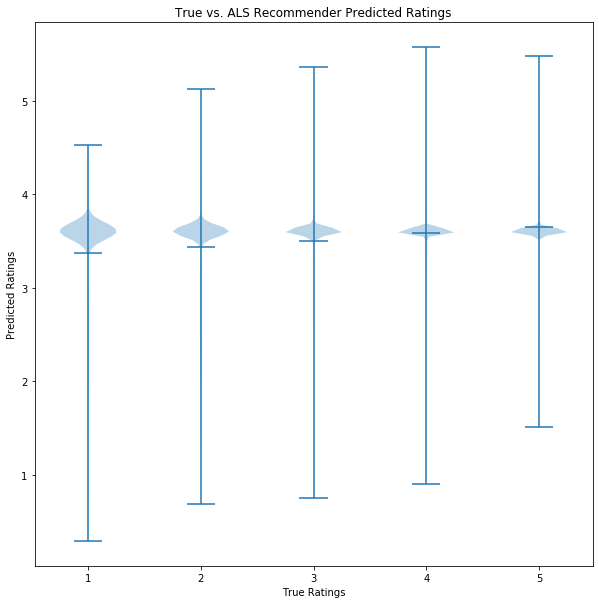

In [82]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,10))
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

# implicit interactions

In [39]:
train = train.withColumn("imp_rating", lit(1))


In [40]:
train.show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|imp_rating|
+----+-----+------+---------+----------+
|5344|  300|     4|960670929|         1|
|5344|  480|     3|960670865|         1|
|5344| 1210|     1|960671010|         1|
|5344| 2330|     4|960671323|         1|
|5344| 3671|     4|960671113|         1|
|5344| 3688|     1|960671208|         1|
|5344| 3724|     4|960671133|         1|
|5345|    6|     5|960671329|         1|
|5345|   21|     3|960671248|         1|
|5345|  110|     5|960671248|         1|
|5345|  172|     3|960670788|         1|
|5345|  260|     5|960671126|         1|
|5345|  306|     4|960671025|         1|
|5345|  381|     5|960671025|         1|
|5345|  457|     4|960671248|         1|
|5345|  474|     4|960671329|         1|
|5345|  858|     5|960671126|         1|
|5345| 1036|     4|960671279|         1|
|5345| 1196|     5|960670761|         1|
|5345| 1197|     5|960671216|         1|
+----+-----+------+---------+----------+
only showing top

The percent of NaNs in predictions for model with rank 50: 79.26%
Average squared error of predictions for model with rank 50: 3.52
Root Mean Squared Error of Predictions for model with rank 50: 1.88
Standard Deviation of True Ratings: 1.12
Standard Deviation of Prediction for model with rank 50: 1.37
RMSE Percentage for model with rank 50: 53.18%


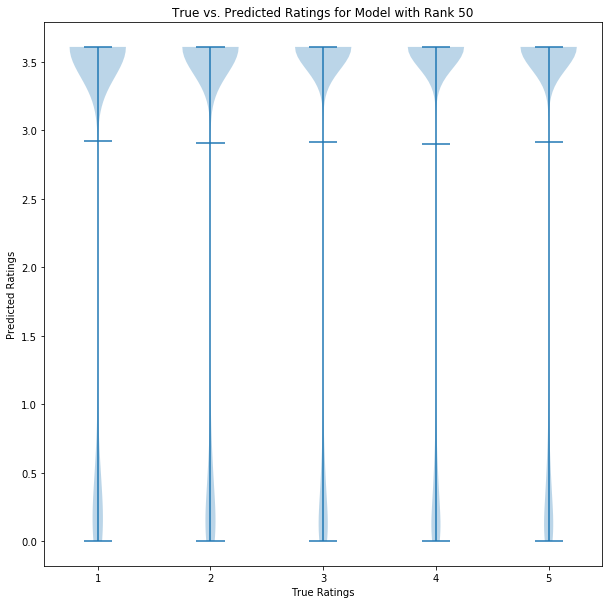

In [18]:
als_model_imp = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

# predict on training data
#predictions_train = recommender_imp.transform(train)

predictions_test = recommender_imp.transform(test)

predictions_pandas = predictions_test.toPandas()

count_nans_prediction = predictions_pandas['prediction'].isna().sum()

percent_nans = count_nans_prediction / predictions_pandas.shape[0]

print(f"The percent of NaNs in predictions for model with rank {r}: {percent_nans*100:.2f}%")

predictions_pandas = predictions_pandas.fillna(training['rating'].mean())

predictions_pandas['squared_error'] = (predictions_pandas['rating'] - predictions_pandas['prediction'])**2

avg_sq_err = predictions_pandas.describe()['squared_error']['mean']
print(f'Average squared error of predictions for model with rank {r}: {avg_sq_err:.2f}')

# Calculate RMSE
rmse = np.sqrt(sum(predictions_pandas['squared_error']) / len(predictions_pandas))
print(f'Root Mean Squared Error of Predictions for model with rank {r}: {rmse:.2f}')

std_rating = ratings.describe()['rating']['std']
std_pred = predictions_pandas.describe()['prediction']['std']

print(f'Standard Deviation of True Ratings: {std_rating:.2f}')
print(f'Standard Deviation of Prediction for model with rank {r}: {std_pred:.2f}')

_mean = predictions_pandas['rating'].mean()
rmsep = rmse / _mean
print(f'RMSE Percentage for model with rank {r}: {rmsep * 100:.2f}%')

# Create array of predictions for violinplot
data = [predictions_pandas['prediction'][ratings['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,10))
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'True vs. Predicted Ratings for Model with Rank {r}')
plt.show()


In [42]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()